Eventually this will be scripted up. Currently just drafting 

In [65]:
import numpy as np
import h5py
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

def read_hdf5_file(data_path, data_name):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]

def load_pickle(load_path):
    with open(load_path, 'rb') as file:
        data = pickle.load(file)
    return data

def calc_masked_MSE_loss(outputs, targets, target_months, use_weights=False, zero_class_weight=None):
    ice_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/monthly_ice_mask.nc").mask

    n_active_cells = 0

    for target_months_subset in target_months:
        n_active_cells += ice_mask.sel(month=target_months_subset).sum().values
    
    # Punish predictions of sea ice in ice free zones 
    if use_weights:
        weights = np.where(targets == 0, zero_class_weight, 1)
        loss = np.sum(((targets - outputs) ** 2) * weights) / n_active_cells
    else:
        loss = np.sum((targets - outputs) ** 2) / n_active_cells

    return loss


In [37]:
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)

targets = h5py.File(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets.h5", 'r')["targets_sea_ice_only"]

linear_forecast = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/linear_forecasts/linear_forecast_all_years.nc").siconc

mse = np.zeros(start_prediction_months.shape)

split_array = np.empty(np.shape(start_prediction_months), dtype=object)
for i,month in enumerate(start_prediction_months):
    months = pd.date_range(month, month + pd.DateOffset(months=5), freq="MS")

    if month in TRAIN_MONTHS: 
        split_array[i] = "train"
    if month in VAL_MONTHS: 
        split_array[i] = "val"
    if month in TEST_MONTHS: 
        split_array[i] = "test"

    # calculate MSE  
    x_pred = linear_forecast.sel(time=months).values
    mse[i] = calc_masked_MSE_loss(targets[i,:,:,:], x_pred, target_months=months.month)

print(f"Loss (modified MSE) of linear forecast for train months: {mse[split_array=='train'].mean()}")
print(f"Loss (modified MSE) of linear forecast for val months: {mse[split_array=='val'].mean()}")
print(f"Loss (modified MSE) of linear forecast for test months: {mse[split_array=='test'].mean()}")



Loss (modified MSE) of linear forecast for train months: 0.04210317563986968
Loss (modified MSE) of linear forecast for val months: 0.04254546125856942
Loss (modified MSE) of linear forecast for test months: 0.039142916422255425


Text(0, 0.5, 'Loss')

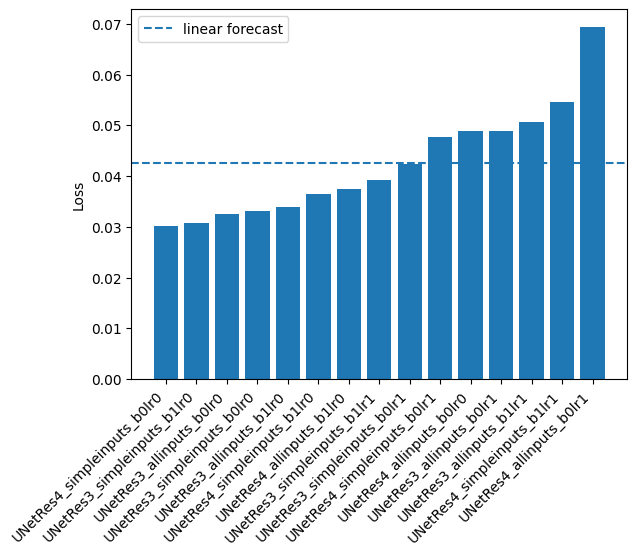

In [145]:

batch_sizes = [16, 32]
learning_rates = [1e-4, 1e-5]
input_configs = ["simple", "all"]
architectures = ["UNetRes3", "UNetRes4"]

val_losses = {}
for i,b in enumerate(batch_sizes):
    for j,lr in enumerate(learning_rates):
        for input_config in input_configs:
            for arch in architectures: 
                model_name = f"{arch}_{input_config}inputs_b{i}lr{j}"
                if os.path.exists(f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl"):
                    model_config_dict = load_pickle(f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl")
                    val_losses[model_name] = model_config_dict["best_val_loss"]

sorted_val_losses = sorted(val_losses.items(), key=lambda item: item[1])
labels, values = zip(*sorted_val_losses)

plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.axhline(y = mse[split_array=='val'].mean(), linestyle='dashed', label='linear forecast')
plt.legend()
plt.ylabel("Loss")


Text(0.5, 0.98, 'Prediction for 02/2016 at 6 lead month')

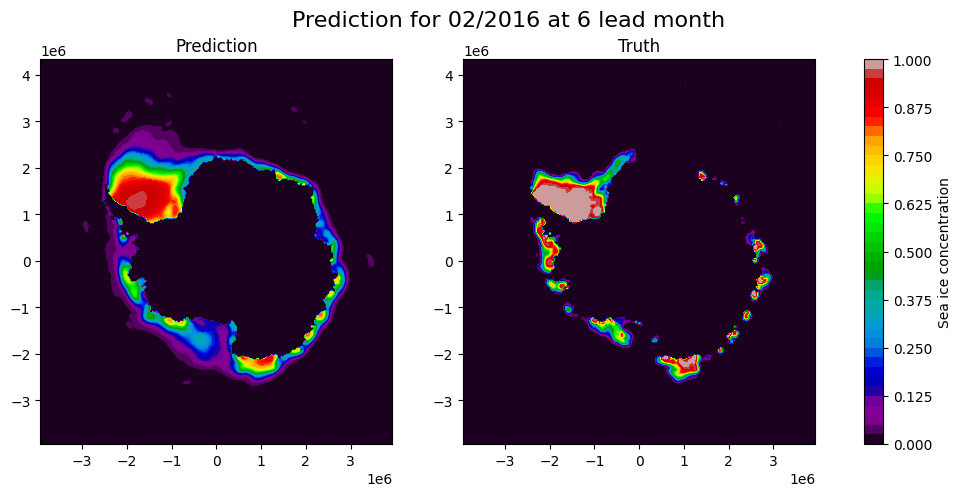

In [161]:
best_model = labels[0]
val_pred = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/{best_model}_val_predictions.npy")

nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
land_mask = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask
sic_land_masked = nsidc_sic.siconc.where(~land_mask, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

time_index = 8
lead_time = 5

prediction = val_pred[time_index,lead_time,2:334,2:318]
ax1.contourf(nsidc_sic.xgrid, nsidc_sic.ygrid, prediction, cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))

truth = sic_land_masked.sel(time=VAL_MONTHS[time_index + lead_time])
cax = ax2.contourf(nsidc_sic.xgrid, nsidc_sic.ygrid, truth, cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))

ax1.set_title("Prediction")
ax2.set_title("Truth")

cbar = fig.colorbar(cax, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('Sea ice concentration')

predicted_month = VAL_MONTHS[time_index + lead_time]

plt.suptitle(rf"Prediction for {predicted_month.month:02}/{predicted_month.year} at {lead_time+1} lead month", fontsize=16)
#plt.savefig(f"../figures/known_issues/{model_name}_faraway_seaice.jpg", dpi=300, bbox_inches='tight')